<a href="https://colab.research.google.com/github/ChanglinWu/DL/blob/main/MLP3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CityU EE5438: Applied Deep Learning

## PyTorch Multi-Layer Perceptron (MLP) Image Classifier With MNIST Dataset

In this example, we will use a popular deep learning framework called PyTorch to create a model that can recognize handwritten digits. The model is known as a Multi-Layer Perceptron (MLP) or Feedforward Neural Network. We will train this model using a dataset called MNIST, which contains 70,000 images of handwritten digits ranging from 0 to 9. Out of these images, we will use 60,000 to teach the model how to recognize and classify these digits. During the training process, we will also use 5,000 images to check and validate how well the model is learning. Once the training is complete, we will test the model on the remaining 5,000 images to see how accurately it can identify new handwritten digits that it has not seen before. This will help us evaluate the model's ability to recognize digits in real-world scenarios.

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_mnist.png'>

References:
- https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)

In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with MNIST dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.4.0+cu121
Device: cuda


In [ ]:
# Set seed for reproducibility
seed = 4016
torch.manual_seed(seed)

# Download MNIST Dataset

This code snippet creates DataLoaders to facilitate the downloading of the training and test sets. The MNIST training dataset, consisting of 6000 samples, is used to train the Model. The test dataset is randomly split into a validation set and a test set, each containing 5000 samples. The data loaders are employed to provide batches of data from the datasets for iteration. The training data comprises batches of images, with each image measuring 28 x 28 pixels. The corresponding labels indicate the correct Fashion labels ("0", "1", "2", "3",...,"9") for each image.

In [ ]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.5,), (0.5,))])  # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.5,), (0.5,))])  # Normalize the image data

# Create the MNIST dataset for the training set with 60,000 images
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)

# Create the MNIST dataset for the test set with 10,000 images
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define the classes for the MNIST dataset
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 897711.55it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 64297.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 247314.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4989661.80it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Visualize image for each class
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

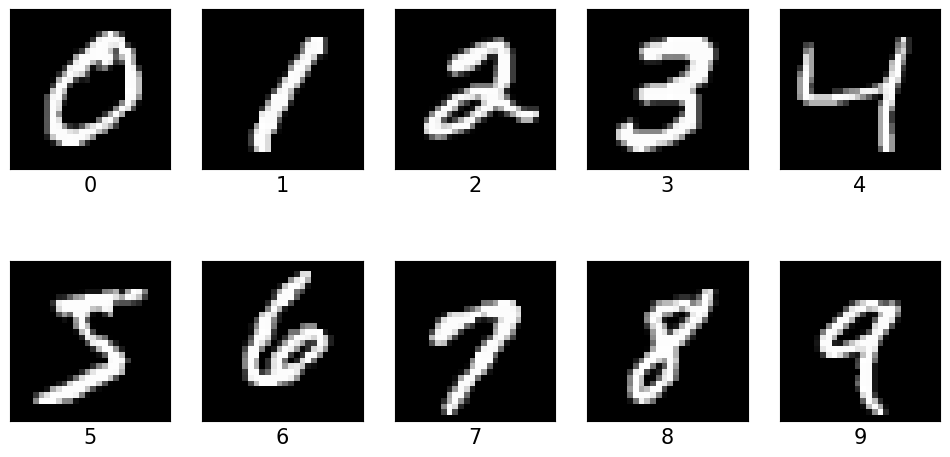

In [ ]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i], cmap='gray')
    i += 1

# Define the MLP Network Architecture

The following code defines a class called MLPNet which inherits from nn.Module. The network has 3 fully-connected layers:

- fc1 takes the 784-pixel MNIST image as input and outputs 128 nodes
- fc2 takes the 128 nodes and outputs 64 nodes
- fc3 takes the 64 nodes and outputs predictions for the 10 classes

The forward method defines the forward pass through the network. It applies ReLU activation on the first two layers and log softmax on the output layer

In [ ]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MLP()
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()

#         # Define the layers of the MLP
#         self.fc1 = nn.Linear(784, 128)  # First fully connected layer, input size 784, output size 128
#         self.fc2 = nn.Linear(128, 64)  # Second fully connected layer, input size 128, output size 64
#         self.fc3 = nn.Linear(64, 10)  # Third fully connected layer, input size 64, output size 10

#         self.activation = nn.ReLU()  # Activation function used between layers

#     def forward(self, x):
#         x = x.view(-1, 784)  # Reshape the input tensor to have dimensions (-1, 784)
#         x = self.activation(self.fc1(x))  # Apply the activation function to the output of the first layer
#         x = self.activation(self.fc2(x))  # Apply the activation function to the output of the second layer
#         x = self.fc3(x)  # Output of the third layer
#         return F.log_softmax(x, dim=1)  # Apply log softmax function to normalize the output probabilities along dimension 1

In [ ]:
model = MLP()

## Print the Model Structure, Number of Parameters and FLOPs

In [ ]:
summary(model=MLP(), input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLP (MLP)                                [1, 1, 28, 28]       [1, 10]              --                   True
├─Flatten (flatten)                      [1, 1, 28, 28]       [1, 784]             --                   --
├─Sequential (linear_relu_stack)         [1, 784]             [1, 10]              --                   True
│    └─Linear (0)                        [1, 784]             [1, 128]             100,480              True
│    └─ReLU (1)                          [1, 128]             [1, 128]             --                   --
│    └─Linear (2)                        [1, 128]             [1, 64]              8,256                True
│    └─ReLU (3)                          [1, 64]              [1, 64]              --                   --
│    └─Linear (4)                        [1, 64]              [1, 10]              650                  True
Total params: 109,38

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify Adam optimizer with defualt setting
# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Specify learning rate scheduler
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

##Training the Network
The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

In [ ]:
EPOCHS = 100

loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_val, acc_hist_val = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(batch)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)  # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0

        # Validation loop
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

        avg_loss_val = loss_val / len(val_set)  # Average validation loss for the epoch
        avg_acc_val = correct_val / len(val_set)  # Average validation accuracy for the epoch
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)

    model.train()  # Set the model back to training mode
#     scheduler.step(avg_loss_val) # Check the scheduler for updating the learning rate

    # Save the model at the end of each epoch
    with open("Models/MLP_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Val Loss: {:.3f}".format(avg_loss_val * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Val Accuracy: {:.2f}%".format(avg_acc_val * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


Training was started.

EPOCH: 1 Train Loss: 0.789 Val Loss: 0.602 Train Accuracy: 43.94% Val Accuracy: 68.78% Time: 7.72s 
EPOCH: 2 Train Loss: 0.394 Val Loss: 0.269 Train Accuracy: 77.42% Val Accuracy: 84.06% Time: 7.34s 
EPOCH: 3 Train Loss: 0.228 Val Loss: 0.192 Train Accuracy: 85.00% Val Accuracy: 87.68% Time: 7.33s 
EPOCH: 4 Train Loss: 0.183 Val Loss: 0.166 Train Accuracy: 87.21% Val Accuracy: 88.90% Time: 7.52s 
EPOCH: 5 Train Loss: 0.162 Val Loss: 0.150 Train Accuracy: 88.38% Val Accuracy: 89.14% Time: 7.44s 
EPOCH: 6 Train Loss: 0.150 Val Loss: 0.139 Train Accuracy: 89.17% Val Accuracy: 90.50% Time: 7.46s 
EPOCH: 7 Train Loss: 0.142 Val Loss: 0.130 Train Accuracy: 89.59% Val Accuracy: 90.78% Time: 7.44s 
EPOCH: 8 Train Loss: 0.136 Val Loss: 0.125 Train Accuracy: 90.05% Val Accuracy: 91.32% Time: 7.30s 
EPOCH: 9 Train Loss: 0.131 Val Loss: 0.121 Train Accuracy: 90.42% Val Accuracy: 91.64% Time: 7.49s 
EPOCH: 10 Train Loss: 0.126 Val Loss: 0.118 Train Accuracy: 90.73% Val Accura

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

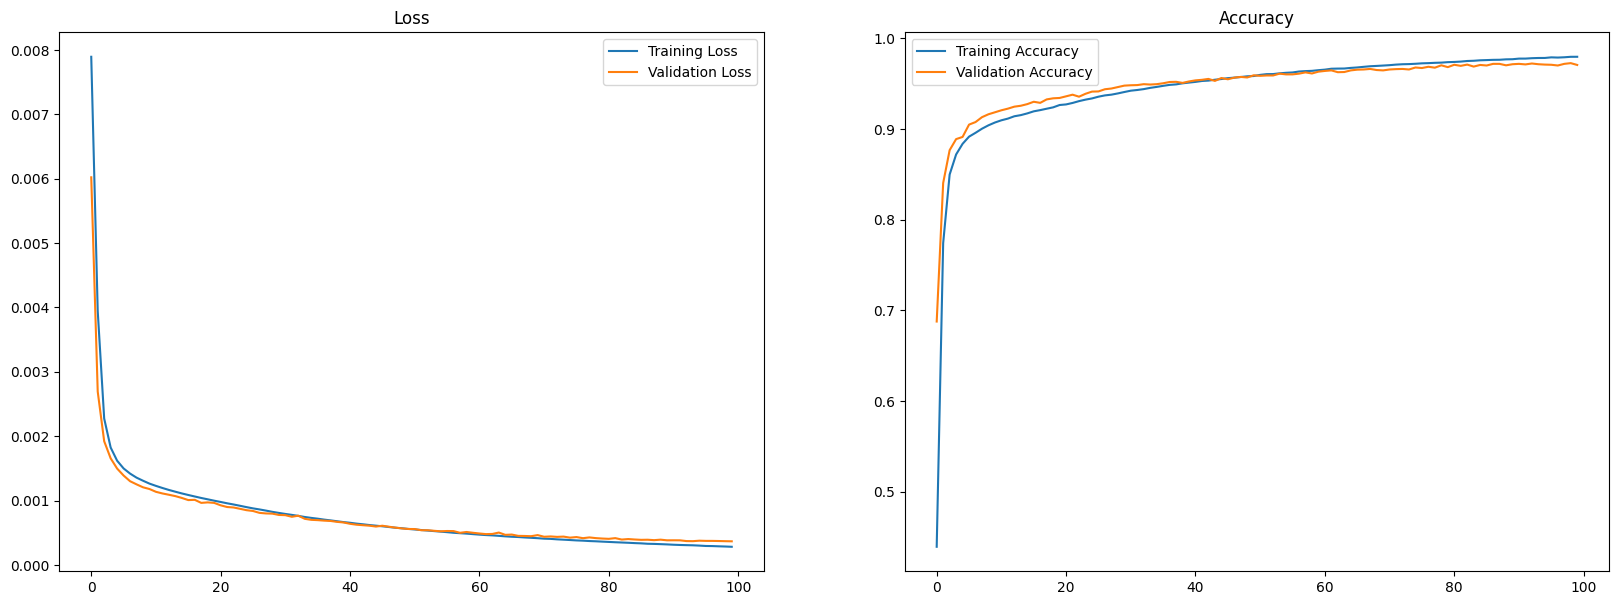

In [ ]:
plots=[(loss_hist,loss_hist_val),(acc_hist,acc_hist_val)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

##Save the trained model

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc)+1

print("Best accuracy on validation set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/MLP_model_{best_epoch}.pth","rb") as f:
    model=pickle.load(f)

Best accuracy on validation set: 97.28%
Best epoch: 99


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


##Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0

model.to(device)
model.eval()

with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

print("Test Loss: {:.2f}".format(test_loss))
print('Test Accuracy on the 5000 test images: %.2f %%' % (100 * correct / len(test_set)))

Test Loss: 0.09
Test Accuracy on the 5000 test images: 96.98 %


# Display the Confusion Matrix

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,0,1,2,3,4,5,6,7,8,9
0,525,0,0,0,0,3,3,1,1,0
1,0,569,2,0,0,0,1,1,1,0
2,4,2,499,2,0,0,2,6,3,0
3,1,0,1,492,0,2,0,0,2,1
4,0,0,1,0,455,0,2,2,1,8
5,3,1,0,5,0,447,2,1,3,3
6,5,3,1,0,3,3,470,1,0,0
7,0,6,4,1,1,1,0,488,0,3
8,5,0,1,4,1,4,3,2,469,3
9,3,5,1,5,7,1,0,3,0,435


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,0,0.973123,0.984991,0.961538,546.0000
1,1,0.981034,0.991289,0.970990,586.0000
2,2,0.970817,0.963320,0.978431,510.0000
3,3,0.976190,0.985972,0.966601,509.0000
4,4,0.972222,0.970149,0.974304,467.0000
5,5,0.965443,0.961290,0.969631,461.0000
6,6,0.970072,0.967078,0.973085,483.0000
7,7,0.967294,0.968254,0.966337,505.0000
8,8,0.965021,0.953252,0.977083,480.0000
9,9,0.952903,0.945652,0.960265,453.0000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.

# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

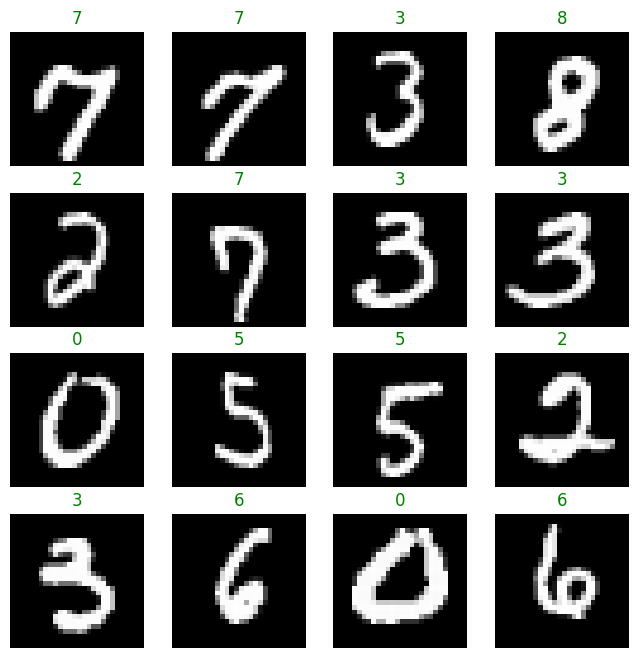

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image, cmap='gray')  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

#Visualize wrongly classified image for each class

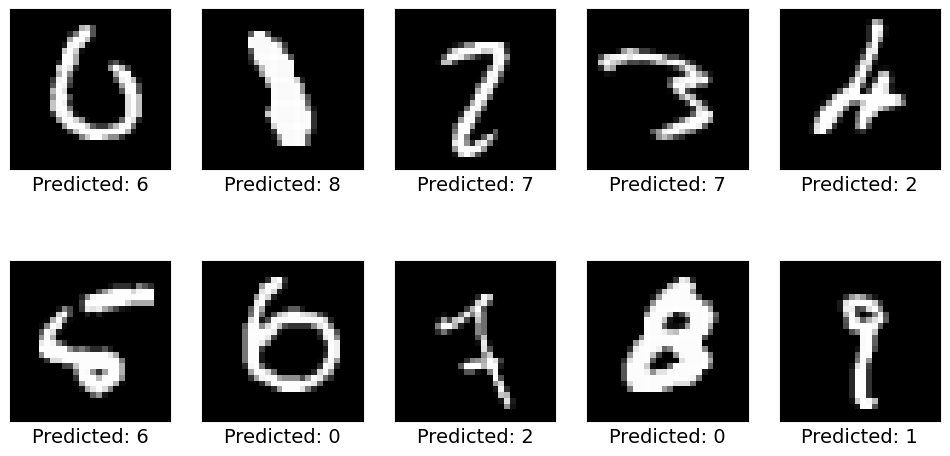

In [ ]:
# Visualize wrongly classified image for each class

# Define the loader for all test data
test_set_all = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2)

pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=14)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1